In [33]:
import torch 
from torchviz import make_dot
import matplotlib.pyplot as plt
from torch import nn 
from sklearn.datasets import load_diabetes
from torchvision import datasets, transforms

from torch import optim 

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from tqdm import tqdm 
from torchsummary import summary 
from sklearn.model_selection import train_test_split

In [2]:
z = torch.tensor(3.0, requires_grad = True)
z

tensor(3., requires_grad=True)

In [3]:
y = z**2
y

tensor(9., grad_fn=<PowBackward0>)

In [4]:
y.backward() # gradients are computed 

In [5]:
z.grad

tensor(6.)

### gradient accumulation and clearing

In [6]:
for i in range(5):
    y = z**2
    y.backward()
    print(z.grad)

tensor(12.)
tensor(18.)
tensor(24.)
tensor(30.)
tensor(36.)


In [7]:
for i in range(5):
    y = z**2
    y.backward()
    print(z.grad)
    z.grad.zero_()

tensor(42.)
tensor(6.)
tensor(6.)
tensor(6.)
tensor(6.)


In [8]:
y = z**2
y.backward()
with torch.no_grad(): 
    z -= 0.2*z.grad
z

tensor(1.8000, requires_grad=True)

### Simple training loop

In [9]:
w = torch.tensor(2.0, requires_grad=True)  # weight
b = torch.tensor(1.0, requires_grad=True) # bias
x = torch.tensor(3.0, requires_grad=False)
y_hat = w*x + b
y_hat

tensor(7., grad_fn=<AddBackward0>)

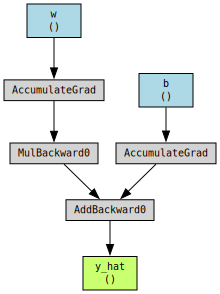

In [10]:
make_dot(y_hat, params={"w": w, "b": b, "y_hat": y_hat})

In [11]:
def plot_loss_vs_learning_rate(learning_rate: float = 0.2):
    x = torch.tensor(3.0, requires_grad=False)
    y = torch.tensor(1.0, requires_grad=False)

    w = torch.tensor(2.0, requires_grad=True)
    b = torch.tensor(1.0, requires_grad=True)
    losses = []
    for i in range(150): 
        y_hat = w*x + b 
        loss = (y_hat - y)**2 
        losses.append(loss.item())

        # print(i, f"w = {w.data}, b = {b.data}")
        # print('loss', loss)
        # print()

        loss.backward()

        with torch.no_grad(): 
            w -= learning_rate*w.grad
            b -= learning_rate*b.grad

        w.grad.zero_(), b.grad.zero_()

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

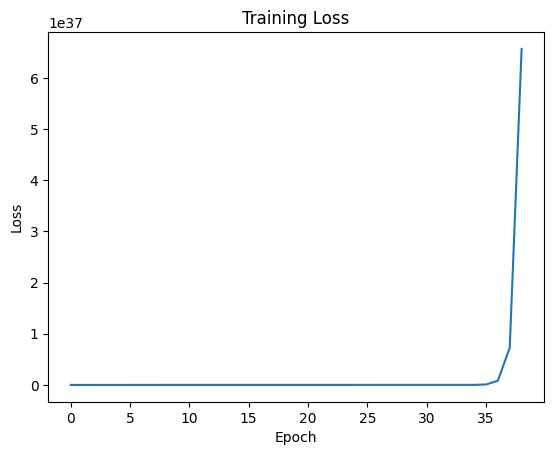

In [12]:
plot_loss_vs_learning_rate()

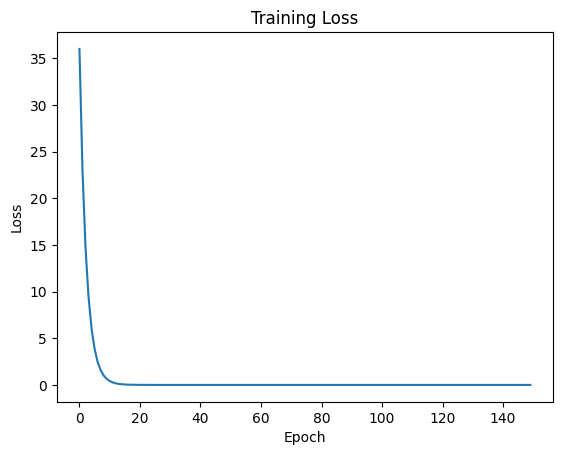

In [13]:
plot_loss_vs_learning_rate(0.01)

### ANN

#### 3-2-3 Artificial Neural Network

- Architecture
    - Input layer: 3 neurons (features)
    - Hidden layer: 2 neurons (pre-activation a1 = X @ W1.T + b1), activation: Sigmoid -> h1
    - Output layer: 3 neurons (pre-activation a2 = h1 @ W2.T + b2), activation: Softmax -> h2

- Parameter shapes
    - W1: (2, 3), b1: (2,)
    - W2: (3, 2), b2: (3,)

- Forward pass (batch X with shape (N, 3))
    1. a1 = X @ W1.T + b1
    2. h1 = sigmoid(a1)
    3. a2 = h1 @ W2.T + b2
    4. h2 = softmax(a2)  # row-wise

- Loss (classification): CrossEntropyLoss (use logits a2 with torch.nn.CrossEntropyLoss)

- Total learnable parameters: (2*3 + 2) + (3*2 + 3) = 8 + 9 = 17

Diagram (conceptual):

Input (3)  -->  Hidden (2)  -->  Output (3)

O O O      ->    O O       ->   O O O

In [14]:
a1_layer = nn.Linear(in_features=3, out_features=2) # preactivation
h1_layer = nn.Sigmoid() # activation 

a2_layer = nn.Linear(in_features=2, out_features=3)
h2_layer = nn.Softmax(dim=1)

In [15]:
torch.manual_seed(42)
X = torch.randn(4, 3)
X

tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]])

In [16]:
a1 = a1_layer.forward(X)
a1

tensor([[ 0.2624, -0.4373],
        [ 0.5514,  0.2211],
        [ 1.3977,  0.2182],
        [ 0.1795, -0.8313]], grad_fn=<AddmmBackward0>)

In [17]:
h1 = h1_layer.forward(a1)
h1

tensor([[0.5652, 0.3924],
        [0.6345, 0.5551],
        [0.8018, 0.5543],
        [0.5447, 0.3034]], grad_fn=<SigmoidBackward0>)

In [18]:
a2 = a2_layer.forward(h1)
a2

tensor([[ 0.6373,  1.1029, -0.9931],
        [ 0.5552,  1.2033, -1.0969],
        [ 0.6160,  1.2714, -1.1432],
        [ 0.6886,  1.0551, -0.9411]], grad_fn=<AddmmBackward0>)

In [19]:
h2 = h2_layer.forward(a2)
h2

tensor([[0.3586, 0.5712, 0.0702],
        [0.3222, 0.6160, 0.0618],
        [0.3228, 0.6217, 0.0556],
        [0.3790, 0.5468, 0.0743]], grad_fn=<SoftmaxBackward0>)

In [20]:
def softmax(X): 
    return torch.exp(X)/torch.sum(torch.exp(X), axis = 1, keepdim=True)

softmax(a2)

tensor([[0.3586, 0.5712, 0.0702],
        [0.3222, 0.6160, 0.0618],
        [0.3228, 0.6217, 0.0556],
        [0.3790, 0.5468, 0.0743]], grad_fn=<DivBackward0>)

In [21]:
network = nn.Sequential(
    nn.Linear(in_features=3, out_features=2), 
    nn.Sigmoid(), 
    nn.Linear(in_features=2, out_features=3), 
    nn.Softmax()
)
network

Sequential(
  (0): Linear(in_features=3, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=3, bias=True)
  (3): Softmax(dim=None)
)

In [22]:
network.forward(X)

c:\Users\ghora\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.3942, 0.2076, 0.3982],
        [0.4034, 0.1988, 0.3977],
        [0.3863, 0.2212, 0.3925],
        [0.3944, 0.2106, 0.3951]], grad_fn=<SoftmaxBackward0>)

In [23]:
print(*network.parameters())

Parameter containing:
tensor([[-0.4557, -0.2662, -0.1630],
        [-0.3471,  0.0545, -0.5702]], requires_grad=True) Parameter containing:
tensor([ 0.5214, -0.4904], requires_grad=True) Parameter containing:
tensor([[ 0.5459,  0.1177],
        [-0.2296,  0.4370],
        [ 0.1102,  0.5713]], requires_grad=True) Parameter containing:
tensor([ 0.0773, -0.2230,  0.1900], requires_grad=True)


diabetes

In [26]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test.values, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

In [46]:
X_train.shape

torch.Size([353, 10])

In [47]:
model = nn.Sequential(
    nn.Linear(in_features=10, out_features=8), 
    nn.Sigmoid(), 
    nn.Linear(in_features=8, out_features=8), 
    nn.Sigmoid(), 
    nn.Linear(in_features=8, out_features=1)
)

model.to(device)

Sequential(
  (0): Linear(in_features=10, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [48]:
y_hat = model.forward(X_train).squeeze() # 2D -> 1D
y_hat[:5]

tensor([0.0042, 0.0041, 0.0038, 0.0037, 0.0035], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [49]:
print(*model.parameters())

Parameter containing:
tensor([[ 0.1539,  0.0539,  0.0860,  0.1039,  0.2408, -0.1359, -0.0711,  0.0862,
          0.0345,  0.2550],
        [-0.1661, -0.0115,  0.0591, -0.0840,  0.2156,  0.0346, -0.2923, -0.0343,
         -0.1434,  0.0307],
        [-0.0368, -0.3137, -0.0576, -0.0303, -0.0932,  0.2905, -0.0690,  0.2032,
          0.0783, -0.2669],
        [ 0.0743,  0.2621, -0.2068, -0.2044,  0.3095,  0.2541, -0.1764,  0.1903,
         -0.0405, -0.3118],
        [ 0.0238,  0.1022, -0.0949,  0.1100, -0.2704,  0.2192,  0.2696,  0.1744,
          0.0536,  0.1041],
        [-0.2288, -0.0790, -0.0302, -0.1760, -0.2336,  0.2127,  0.2146, -0.2872,
          0.1006,  0.1286],
        [ 0.3004,  0.1830,  0.2907, -0.1035,  0.2215,  0.2572, -0.2986, -0.2538,
          0.0640,  0.1727],
        [-0.1571,  0.0348, -0.0005,  0.0800, -0.1699,  0.1784,  0.2103, -0.2194,
          0.0031,  0.0009]], device='cuda:0', requires_grad=True) Parameter containing:
tensor([ 0.1015,  0.2946,  0.0927, -0.0719,  0

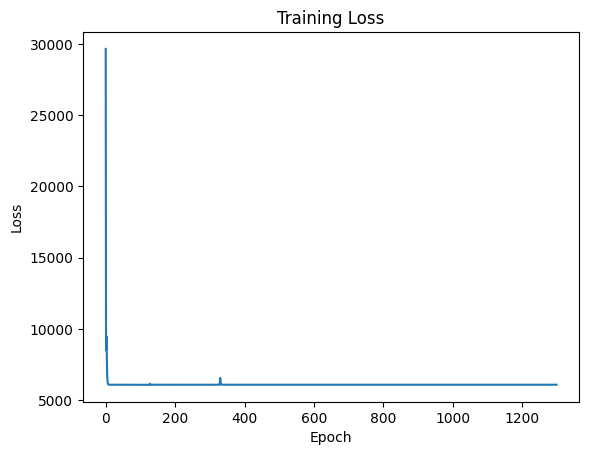

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features=10, out_features=8), 
    nn.Sigmoid(), 
    nn.Linear(in_features=8, out_features=8), 
    nn.Sigmoid(), 
    nn.Linear(in_features=8, out_features=1)
)
model.to(device)

loss_func = nn.MSELoss()
epochs = 1300 
learning_rate = 0.1 
losses = []
for epoch in range(epochs): 
    y_hat = model.forward(X_train)

    loss = loss_func(y_hat.squeeze(), y_train)
    losses.append(loss.item())
    # print("loss --> ", loss.item())

    loss.backward()

    with torch.no_grad(): 
        for param in model.parameters(): 
            param -= learning_rate*param.grad

    model.zero_grad()  # making grads 0

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [60]:
class ANNModel(nn.Module): 
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.network = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=8), 
            nn.BatchNorm1d(8),
            nn.Sigmoid(), 
            nn.Dropout(p=0.3),

            nn.Linear(in_features=8, out_features=8), 
            nn.Sigmoid(), 
            nn.Linear(in_features=8, out_features=self.out_features)
        )

    def forward(self, X): 
        return self.network(X)
    
    

In [61]:
model1 = ANNModel(10, 1)
model1.to(device)

ANNModel(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
summary(model1, input_size = (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              88
       BatchNorm1d-2                    [-1, 8]              16
           Sigmoid-3                    [-1, 8]               0
           Dropout-4                    [-1, 8]               0
            Linear-5                    [-1, 8]              72
           Sigmoid-6                    [-1, 8]               0
            Linear-7                    [-1, 1]               9
Total params: 185
Trainable params: 185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


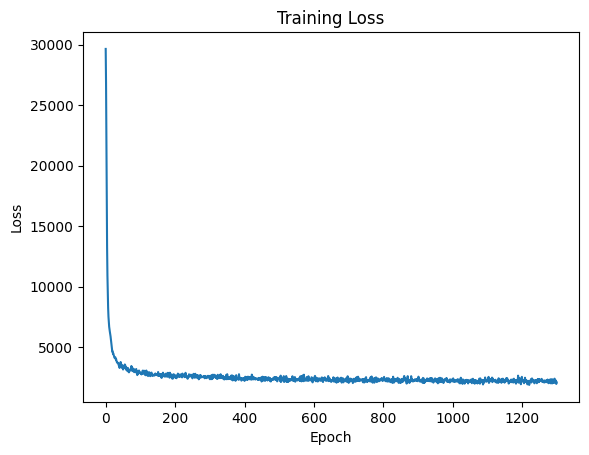

In [63]:
losses = []
epochs = 1300 
model1.train()
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr = 0.01)
for epoch in range(epochs): 
    y_hat = model1.forward(X_train)

    loss = loss_func(y_hat.squeeze(), y_train)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()


plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [64]:
model1.eval() # batchnorm and dropout will freeze 
with torch.no_grad(): 
    y_hat = model1.forward(X_test)

    loss = loss_func(y_hat.squeeze(), y_test)
    print(loss.item())

3040.97607421875


### Minibatch GD

In [73]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=33, shuffle = True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=33, shuffle = False)

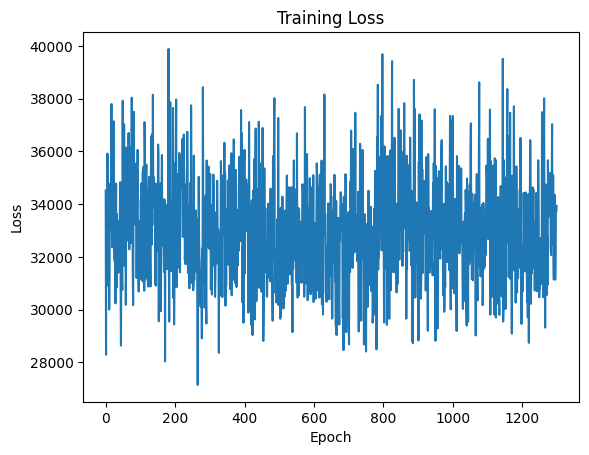

In [74]:
losses = []
epochs = 1300 
model1.train()
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr = 0.01)
for epoch in range(epochs): 
    loss_per_epoch = 0
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)
        y_hat = model1.forward(features)

        loss = loss_func(y_hat.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        loss_per_epoch += loss.item()

        optimizer.step()
    losses.append(loss_per_epoch)


plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [77]:
model1.eval() # batchnorm and dropout will freeze 
with torch.no_grad(): 
    loss_per_epoch = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        y_hat = model1.forward(features)

        loss = loss_func(y_hat.squeeze(), labels)
        loss_per_epoch += loss.item()

print(loss_per_epoch)

8359.28271484375


### image classification 

In [6]:
full_data = datasets.ImageFolder('PlantVillage', transform=None)
print(len(full_data), full_data.classes)

2152 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


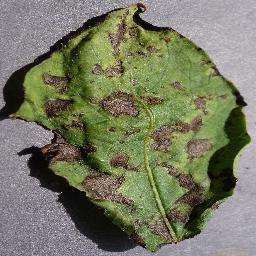

In [10]:
image, label = full_data[0]
image

In [12]:
full_data = datasets.ImageFolder('PlantVillage', transform=transforms.ToTensor())
image, label = full_data[0]
print(image, image.shape)

tensor([[[0.4824, 0.6314, 0.5804,  ..., 0.6824, 0.6706, 0.6627],
         [0.5137, 0.5804, 0.5569,  ..., 0.7216, 0.7059, 0.6902],
         [0.5882, 0.5255, 0.5176,  ..., 0.7020, 0.6863, 0.6745],
         ...,
         [0.5843, 0.4588, 0.5098,  ..., 0.6275, 0.6314, 0.6314],
         [0.4235, 0.4118, 0.4941,  ..., 0.6353, 0.6392, 0.6431],
         [0.5765, 0.3647, 0.5020,  ..., 0.6627, 0.6745, 0.6784]],

        [[0.4706, 0.6196, 0.5686,  ..., 0.6706, 0.6588, 0.6510],
         [0.5020, 0.5686, 0.5451,  ..., 0.7098, 0.6941, 0.6784],
         [0.5765, 0.5137, 0.5059,  ..., 0.6902, 0.6745, 0.6627],
         ...,
         [0.5686, 0.4431, 0.4941,  ..., 0.6196, 0.6235, 0.6235],
         [0.4078, 0.3961, 0.4784,  ..., 0.6275, 0.6314, 0.6353],
         [0.5608, 0.3490, 0.4863,  ..., 0.6549, 0.6667, 0.6706]],

        [[0.4980, 0.6471, 0.5961,  ..., 0.6980, 0.6863, 0.6784],
         [0.5294, 0.5961, 0.5725,  ..., 0.7373, 0.7216, 0.7059],
         [0.6039, 0.5412, 0.5333,  ..., 0.7176, 0.7020, 0.

In [13]:
train_set, test_set = random_split(
    full_data, 
    [int(len(full_data)*0.8), len(full_data)-int(len(full_data)*0.8)]
)

In [14]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [19]:
class PotatoCNN(nn.Module): 
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.convolution = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1, stride = 1), # 256
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, padding=0, stride=2), #(256-2)/2 + 1 =128
            nn.Conv2d(32, out_channels=64, kernel_size=3, padding=1, stride=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), # (128-2)/2+1 = 64
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=64**3, out_features=128), 
            nn.ReLU(), 
            nn.Linear(in_features=128, out_features=32), 
            nn.ReLU(), 
            nn.Linear(in_features=32, out_features=3), 
        )

    def forward(self, X): 
        X = self.convolution(X)
        X = self.classifier(X)
        return X 

In [21]:
summary(PotatoCNN(3).to(device='cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
           Flatten-7               [-1, 262144]               0
            Linear-8                  [-1, 128]      33,554,560
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 32]           4,128
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 3]              99
Total params: 33,578,179
Trainable params: 33,578,179
Non-trainable params: 0
-------------------------

100%|██████████| 30/30 [02:54<00:00,  5.81s/it]


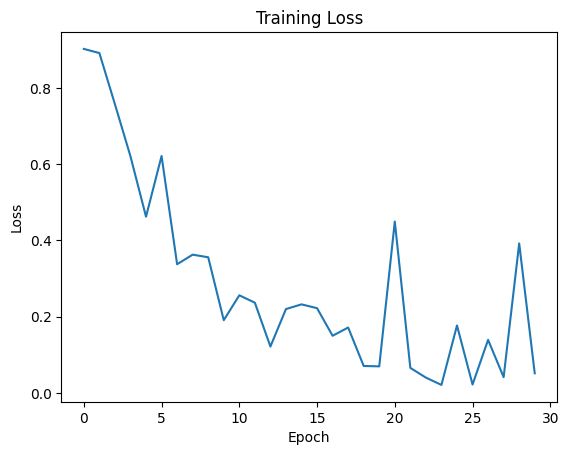

In [37]:
torch.manual_seed(42)

model = PotatoCNN(3)
model.to('cuda')

optimizer = optim.SGD(model.parameters(), lr = 0.01)
EPOCHS = 30
losses = []
model.train()
for epoch in tqdm(range(EPOCHS)): 
    loss_per_epoch = 0 
    for features, labels in train_loader: 
        features = features.to('cuda')
        labels = labels.to('cuda')

        y_pred = model.forward(features)

        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(y_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss 

    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [36]:
losses

[tensor(0.9026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.8918, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.7577, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6208, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.4757, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.6203, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3636, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3580, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1899, device='cuda:0', grad_fn=<NllLossBackward0>)]

In [38]:
model.eval()

total = 0 
correct = 0
with torch.no_grad(): 
    for features, labels in test_loader: 
        features = features.to('cuda')
        labels = labels.to('cuda')

        y_pred = model.forward(features)

        _, predicted = torch.max(y_pred, 1)

    
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
    
print(correct/total)

0.951276102088167


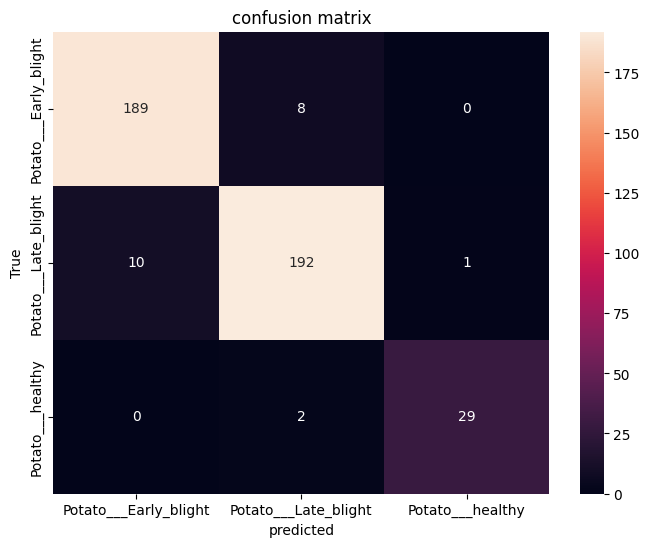

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

y_true, y_pred = [], []

with torch.no_grad(): 
    for batch_features, batch_labels in test_loader: 
        batch_features, batch_labels = batch_features.to('cuda'), batch_labels.to('cuda')
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(batch_labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_data.classes, yticklabels=full_data.classes)
plt.xlabel('predicted')
plt.ylabel('True')
plt.title('confusion matrix')
plt.show()